## Exercise 2.11 - Non-Stationary Hyper-Parameter Sweep

Make a figure analogous to Figure 2.6 for the non-stationary case outlined in Exercise 2.5. Include
the constant-step-size $\epsilon$-greedy algorithm with $\epsilon$=0.1. Use runs of 200,000 steps
and, as a performance measure for each algorithm and parameter setting, use the average reward over
the last 100,000 steps.  


In [1]:
!pip3 -q install ray

In [3]:
import gym
import ray.tune
import numpy as np
import matplotlib.pyplot as plt

from bandit import run_episode
from gamblers import AveragingGambler, EpsilonGreedyGambler, \
                     OptimisticGambler, UCBGambler, GradientGambler

### Gamblers

In [5]:
n = 10
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True)

In [6]:
gambler = AveragingGambler(bandit.action_space.n)
rewards, corrects, steps = run_episode(bandit, gambler, 7)

print(gambler.__class__.__name__)
print(f"Reward: {np.mean(rewards):.3} Arm*: {np.mean(corrects):.1%}")

AveragingGambler
Reward: 1.49 Arm*: 87.8%


In [7]:
gambler = EpsilonGreedyGambler(bandit.action_space.n)
rewards, corrects, steps = run_episode(bandit, gambler, 7)

print(gambler.__class__.__name__)
print(f"Reward: {np.mean(rewards):.3} Arm*: {np.mean(corrects):.1%}")

EpsilonGreedyGambler
Reward: 1.45 Arm*: 83.6%


In [8]:
gambler = OptimisticGambler(bandit.action_space.n)
rewards, corrects, steps = run_episode(bandit, gambler, 7)

print(gambler.__class__.__name__)
print(f"Reward: {np.mean(rewards):.3} Arm*: {np.mean(corrects):.1%}")

OptimisticGambler
Reward: 1.29 Arm*: 77.2%


In [9]:
gambler = UCBGambler(bandit.action_space.n)
rewards, corrects, steps = run_episode(bandit, gambler, 7)

print(gambler.__class__.__name__)
print(f"Reward: {np.mean(rewards):.3} Arm*: {np.mean(corrects):.1%}")

UCBGambler
Reward: 1.62 Arm*: 97.0%


In [10]:
gambler = GradientGambler(bandit.action_space.n)
rewards, corrects, steps = run_episode(bandit, gambler, 7)

print(gambler.__class__.__name__)
print(f"Reward: {np.mean(rewards):.3} Arm*: {np.mean(corrects):.1%}")

GradientGambler
Reward: 1.51 Arm*: 91.7%


### Reproduction of Figure 2.6

In [ ]:
stationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True)
nonstationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False)
nonstationary._max_episode_steps = 200_000

In [3]:
seed = np.random.randint(2 ** 32 - 1)

def run_experiment(bandit, num_episodes, gambler, reporter):
    rewards, rewards2, corrects, steps = [], [], [], 0
    
    for episode in range(num_episodes):
        reward, correct, step = run_episode(bandit, gambler, seed + episode)
        rewards += [np.mean(reward)]
        rewards2 += [np.mean(reward[reward.shape[0] // 2:])]
        corrects += [np.mean(correct)]
        steps += step

    rewards = np.array(rewards)
    rewards2 = np.array(rewards)
    corrects = np.array(corrects)

    reporter(
        bandit=str(bandit.unwrapped),
        gambler=gambler.__class__.__name__,
        mean_reward=np.mean(rewards), std_reward=np.std(rewards),
        mean_reward2=np.mean(rewards2), std_reward2=np.std(rewards2),
        mean_correct_arm=np.mean(corrects), std_correct_arm = np.std(corrects),
        episodes_total=num_episodes,
        timesteps_total=steps,
        total_steps=steps,
        done=True
    )

2019-08-17 12:42:02,213	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-08-17_12-42-02_207195_867/logs.
2019-08-17 12:42:02,321	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:34184 to respond...
2019-08-17 12:42:02,449	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:62329 to respond...
2019-08-17 12:42:02,459	INFO services.py:809 -- Starting Redis shard with 3.44 GB max memory.
2019-08-17 12:42:02,472	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-08-17_12-42-02_207195_867/logs.
2019-08-17 12:42:02,475	WARNING services.py:1330 -- WARNING: The default object store size of 5.15 GB will use more than 50% of the available memory on this node (8.06 GB). Consider setting the object store memory manually to a smaller size to avoid memory contention with other applications.
2019-08-17 12:42:02,476	INFO services.py:1475 -- Starting the Plasma object store with 5.15 GB memory using

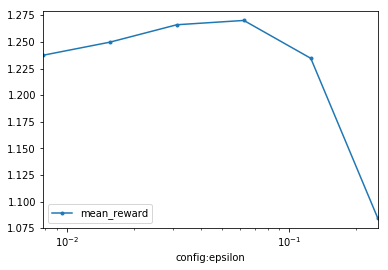

In [5]:
def greedy_experiment(config, reporter):
    gambler = EpsilonGreedyGambler(n, alpha=0.1, epsilon=config['epsilon'])
    run_experiment(config['bandit'], config['num_episodes'], gambler, reporter)

ray.tune.run(greedy_experiment, name='epsilon-greedy',
    config={'epsilon': ray.tune.grid_search([2 ** n for n in range(-7, -1)]),
            'bandit': stationary, 'num_episodes': 2_000},
    local_dir='./stationary/', verbose=0)

analysis = ray.tune.Analysis('./stationary/epsilon-greedy')
df = analysis.dataframe().sort_values(by=['config:epsilon'])
df.plot(x='config:epsilon', y='mean_reward', logx=True, marker='.')

2019-08-13 18:17:00,210	INFO trial_runner.py:176 -- Starting a new experiment.


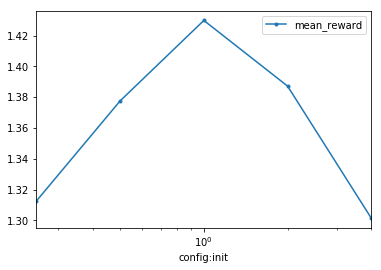

In [6]:
def optimistic_experiment(config, reporter):
    gambler = OptimisticGambler(n, epsilon=0, alpha=0.1, init=config['init'])
    run_experiment(config['bandit'], config['num_episodes'], gambler, reporter)

ray.tune.run(optimistic_experiment, name='optimistic',
    config={'init': ray.tune.grid_search([2 ** n for n in range(-2, 3)]),
            'bandit': stationary, 'num_episodes': 2_000},
    local_dir='./stationary/', verbose=0)

analysis = ray.tune.Analysis('./stationary/optimistic')
df = analysis.dataframe().sort_values(by=['config:init'])
df.plot(x='config:init', y='mean_reward', logx=True, marker='.')

2019-08-13 18:17:44,798	INFO trial_runner.py:176 -- Starting a new experiment.


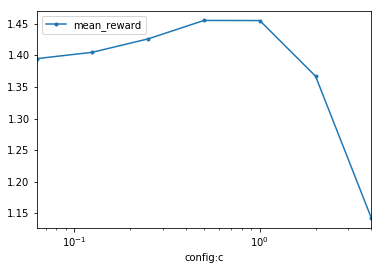

In [7]:
def ucb_experiment(config, reporter):
    gambler = UCBGambler(n, c=config['c'])
    run_experiment(config['bandit'], config['num_episodes'], gambler, reporter)

ray.tune.run(ucb_experiment, name='ucb',
    config={'c': ray.tune.grid_search([2 ** n for n in range(-4, 3)]),
            'bandit': stationary, 'num_episodes': 2_000},
    local_dir='./stationary/', verbose=0)

analysis = ray.tune.Analysis('./stationary/ucb')
df = analysis.dataframe().sort_values(by=['config:c'])
df.plot(x='config:c', y='mean_reward', logx=True, marker='.')

2019-08-13 18:19:45,632	INFO trial_runner.py:176 -- Starting a new experiment.


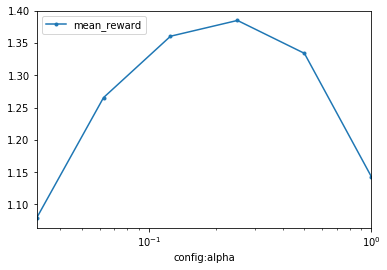

In [8]:
def gradient_experiment(config, reporter):
    gambler = GradientGambler(n, alpha=config['alpha'])
    run_experiment(config['bandit'], config['num_episodes'], gambler, reporter)

ray.tune.run(gradient_experiment, name='gradient',
    config={'alpha': ray.tune.grid_search([2 ** n for n in range(-5, 1)]),
            'bandit': stationary, 'num_episodes': 2_000},
    local_dir='./stationary/', verbose=0)

analysis = ray.tune.Analysis('./stationary/gradient')
df = analysis.dataframe().sort_values(by=['config:alpha'])
df.plot(x='config:alpha', y='mean_reward', logx=True, marker='.')

In [5]:
def comparison_plot(df, mean='mean_reward'):
    df = df.sort_values(by=['config:epsilon', 'config:init', 'config:c', 'config:alpha'])
    fig = plt.figure()
    gca = fig.gca()

    dfg = df[df['gambler'] == 'EpsilonGreedyGambler']
    gca.plot(dfg['config:epsilon'].values, dfg[mean].values,
             marker='.', label=r'Greedy - $\epsilon$')

    dfg = df[df['gambler'] == 'OptimisticGambler']
    gca.errorbar(dfg['config:init'].values, dfg[mean].values,
                 marker='.', label=r'Optimistic - $Q_1$')

    dfg = df[df['gambler'] == 'UCBGambler']
    gca.errorbar(dfg['config:c'].values, dfg[mean].values,
                 marker='.', label=r'UCB - $c$')
    
    dfg = df[df['gambler'] == 'GradientGambler']
    gca.errorbar(dfg['config:alpha'].values, dfg[mean].values,
                 marker='.', label=r'Gradient - $\alpha$')
    
    gca.semilogx()
    gca.set_xlabel('Hyperparameter')
    gca.set_ylabel('Mean Reward')

    fig.set_size_inches(10, 5)
    fig.legend()

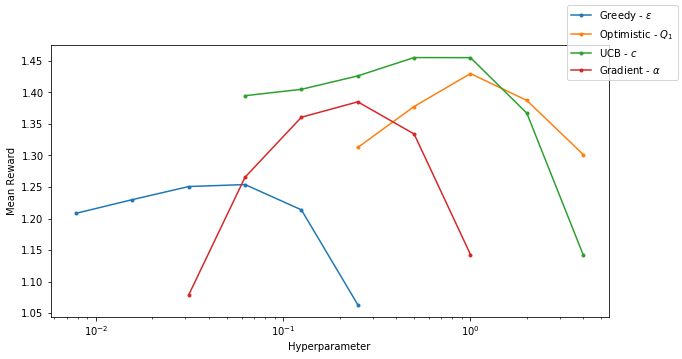

In [6]:
analysis = ray.tune.Analysis('./stationary')
df = analysis.dataframe()
comparison_plot(df, 'mean_reward')

### Hyperparameter Performance in a Non-Stationary Problem

2019-08-17 12:42:50,202	INFO trial_runner.py:176 -- Starting a new experiment.


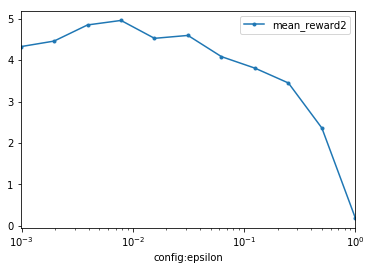

In [6]:
ray.tune.run(greedy_experiment, name='epsilon-greedy',
    config={'epsilon': ray.tune.grid_search([2 ** n for n in range(-10, 1)]),
            'bandit': nonstationary, 'num_episodes': 50},
    local_dir='./nonstationary/', verbose=0)

analysis = ray.tune.Analysis('./nonstationary/epsilon-greedy')
df = analysis.dataframe().sort_values(by=['config:epsilon'])
df.plot(x='config:epsilon', y='mean_reward2', logx=True, marker='.')

2019-08-13 18:34:53,478	INFO trial_runner.py:176 -- Starting a new experiment.


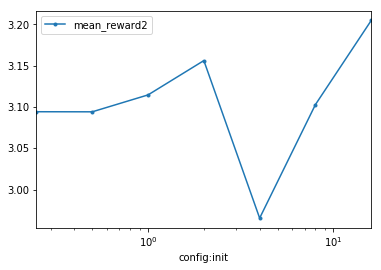

In [12]:
ray.tune.run(optimistic_experiment, name='optimistic',
    config={'init': ray.tune.grid_search([2 ** n for n in range(-2, 5)]),
            'bandit': nonstationary, 'num_episodes': 50},
    local_dir='./nonstationary/', verbose=0)

analysis = ray.tune.Analysis('./nonstationary/optimistic')
df = analysis.dataframe().sort_values(by=['config:init'])
df.plot(x='config:init', y='mean_reward2', logx=True, marker='.')

2019-08-13 18:41:37,711	INFO trial_runner.py:176 -- Starting a new experiment.


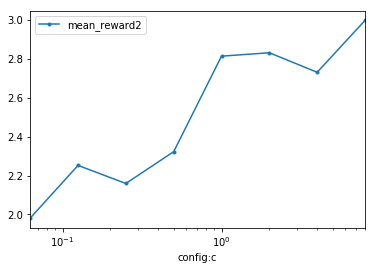

In [13]:
ray.tune.run(ucb_experiment, name='ucb',
    config={'c': ray.tune.grid_search([2 ** n for n in range(-4, 4)]),
            'bandit': nonstationary, 'num_episodes': 50},
    local_dir='./nonstationary/', verbose=0)

analysis = ray.tune.Analysis('./nonstationary/ucb')
df = analysis.dataframe().sort_values(by=['config:c'])
df.plot(x='config:c', y='mean_reward2', logx=True, marker='.')

2019-08-13 18:55:40,842	INFO trial_runner.py:176 -- Starting a new experiment.


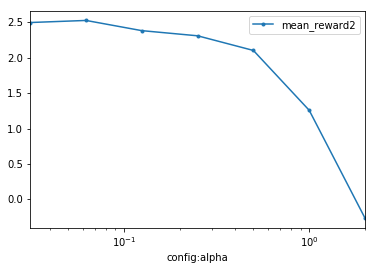

In [14]:
ray.tune.run(gradient_experiment, name='gradient',
    config={'alpha': ray.tune.grid_search([2 ** n for n in range(-5, 2)]),
            'bandit': nonstationary, 'num_episodes': 50},
    local_dir='./nonstationary/', verbose=0)

analysis = ray.tune.Analysis('./nonstationary/gradient')
df = analysis.dataframe().sort_values(by=['config:alpha'])
df.plot(x='config:alpha', y='mean_reward2', logx=True, marker='.')

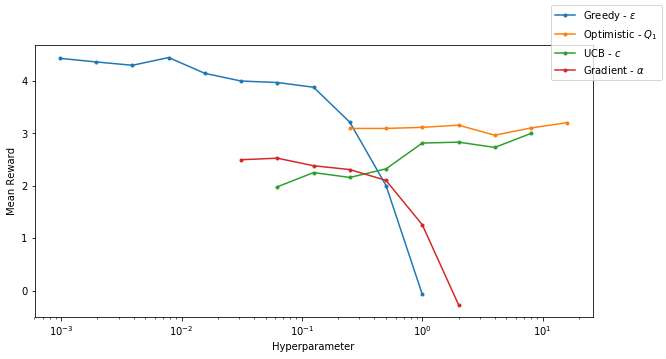

In [7]:
analysis = ray.tune.Analysis('./nonstationary')
df = analysis.dataframe()
comparison_plot(df, 'mean_reward2')